## NOTES:
- The following are experimental plots for data visualization related to the eventual publication of this study

## Imports

In [1]:
#Python3.10
import numpy as np
import pandas as pd 
import seaborn as sns
import geopandas as gpd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import plotly.graph_objects as go
from importlib import reload
import mapclassify

from mpl_toolkits.axes_grid1 import make_axes_locatable
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

# Custom modules are imported in multiple locations to faciliate easy reloading when edits are made to their respective files
import Src.classes as cl
import Src.func as fn
reload(cl)
reload(fn)

<module 'Src.func' from 'c:\\Users\\Alek\\OneDrive - University of California, Davis\\WORK\\DahlkeLab_LAWR\\Src\\func.py'>

Global Shapefiles:

In [2]:
# Takes about 30s to import these four files, but then they can be used everywhere in this notebook
huc2_shape = gpd.read_file('ShapeFiles/HUC2/_Master_HUC2/master_huc2.shp')
huc4_shape = gpd.read_file('ShapeFiles/HUC4/_Master_HUC4/master_huc4.shp')
aq_shape = gpd.read_file('ShapeFiles/Aquifers/_Master_Aquifer/master_aquifer.shp')
stream_network = gpd.read_file('ShapeFiles/Lower48/stream_network.shp')

## Plot 1: Single Aquifer Metrics by HUC4 Plot
Visualizing the single highest {metric} per HUC4 for a given aquifer -- IN PROGRESS

In [62]:
aquifer = cl.high_plains_aquifer
range = 30
quantile = 90
metric = 'annual_hmf'
dataset = f'Prelim_Data/{aquifer.name}/{aquifer.name}_{range}_{quantile}.xlsx'

try:
    df_1 = pd.read_excel(dataset, dtype=fn.DATASET_DTYPES)
    df_1, _ = fn.filter_by_valid(df_1)
    df_1 = df_1.reset_index(drop=True)
except Exception as e:
    print(e)
    df_1 = pd.DataFrame()    

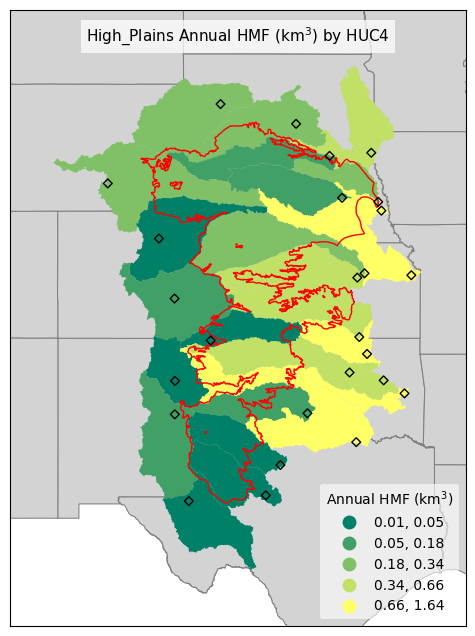

In [63]:
fig, ax = plt.subplots(figsize=(8, 8))
title = plt.title(f"{aquifer.name} {fn.FLOW_METRIC_UNITS[metric]} by HUC4", x=0.5, y=0.935, fontsize=11)
title.set_bbox({'facecolor': 'white', 'alpha': 0.75, 'edgecolor': 'none'})

legend_frmt = {
    "title": f"{fn.FLOW_METRIC_UNITS[metric]}",
    "loc": "lower right",
    "reverse": False,
    "facecolor": "white",
    "alignment": 'center',
    "edgecolor": 'none',
    "framealpha": 0.60
}

# Background plots
fn.plot_lower_48(ax, facecolor='lightgray', edgecolor='gray')
#fn.plot_stream_network(stream_network, ax)

huc4_shape_1 = huc4_shape[huc4_shape['huc4_code'].isin(aquifer.huc4s)]
if not df_1.empty:
    huc_max = df_1.groupby('huc4_code')[metric].idxmax()
    df_1 = df_1.loc[huc_max]
    gdf_1 = huc4_shape_1.merge(df_1, on='huc4_code')
    gdf_1.plot(ax=ax, column=metric, scheme="QUANTILES", cmap='summer', legend=True, legend_kwds=legend_frmt, alpha=1.0, edgecolor='none', linewidth=0.35)
    
aq_shape_1 = aq_shape[aq_shape['aq_name'] == aquifer.name]
aq_shape_1.plot(ax=ax, facecolor='none', edgecolor='red', linewidth=1.0, alpha=1.0)

if not df_1.empty:
    plt.scatter(gdf_1['dec_long_va'], gdf_1['dec_lat_va'], color='none', edgecolor='black', marker='D', s=20, alpha=1.0)  
    
xmin, xmax, ymin, ymax = fn.set_plot_bounds(huc4_shape_1, padding=1.75)
ax.set_xlim(xmin, xmax)
ax.set_ylim(ymin, ymax)
ax.set_yticks([])
ax.set_xticks([])
plt.show()

## Plot 2: All Aquifer 3-Month, 6-Month, Annual HMF

In [74]:
aquifers = cl.ALL_AQUIFERS
range = 30
quantile = 90
dataset = f'Prelim_Data/_National_Metrics/National_Metrics_{range}_{quantile}.xlsx'

try:
    df_2 = pd.read_excel(dataset, dtype=fn.DATASET_DTYPES)
    df_2, _ = fn.filter_by_valid(df_2)
    df_2 = df_2.reset_index(drop=True)
except Exception as e:
    print(e)
    df_2 = pd.DataFrame()  

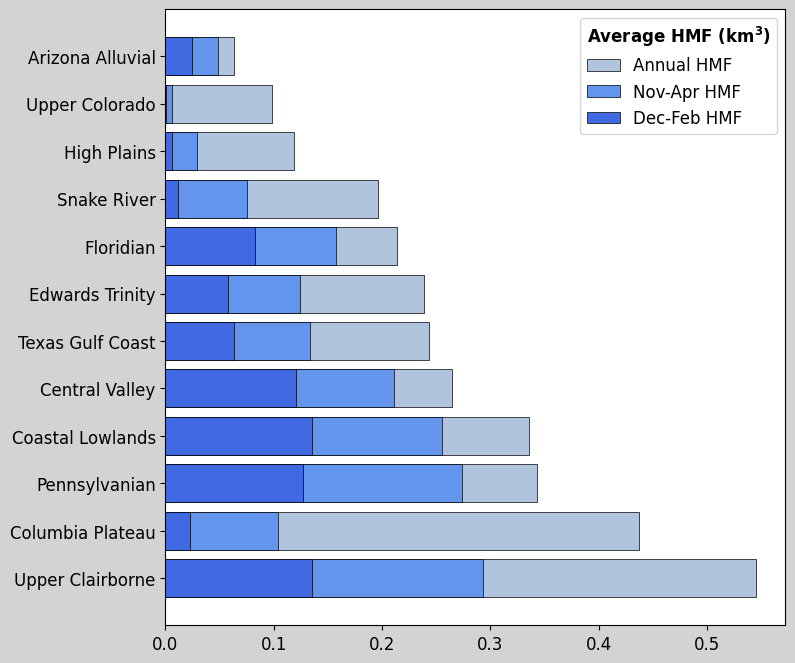

In [76]:
# Data init
df_to_plot = pd.DataFrame()
for aq in cl.ALL_AQUIFERS:
    df_temp = df_2[df_2['huc4_code'].isin(aq.huc4s)]
    
    data = {
        'aq_name': aq.name.replace('_', ' '),
        'annual_hmf': df_temp['annual_hmf'].mean(),
        'six_mo_hmf': df_temp['six_mo_hmf'].mean(),
        'three_mo_hmf': df_temp['three_mo_hmf'].mean(),
    }
    
    df_to_plot = pd.concat([df_to_plot, pd.DataFrame(data, index=[0])])
df_to_plot = df_to_plot.sort_values('annual_hmf', ascending=False)

# Plotting
fig, ax = plt.subplots(figsize=(8, 8), facecolor='lightgray')
plt.barh(df_to_plot['aq_name'], df_to_plot['annual_hmf'], color='lightsteelblue', label="Annual HMF" ,edgecolor='black', linewidth=0.5)
plt.barh(df_to_plot['aq_name'], df_to_plot['six_mo_hmf'],color='cornflowerblue', label="Nov-Apr HMF", edgecolor='black', linewidth=0.5)
plt.barh(df_to_plot['aq_name'], df_to_plot['three_mo_hmf'], color='royalblue', label="Dec-Feb HMF", edgecolor='black', linewidth=0.5)

legend = plt.legend(alignment='left', fontsize=12)
legend.set_title('Average HMF ($\mathregular{km^3}$)', {'weight': 'bold', 'size': 12})
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
#ax.spines['top'].set_visible(False)
#ax.spines['right'].set_visible(False)
#ax.spines['left'].set_visible(False)
#ax.set_facecolor('lightgray')
plt.show()

The same plot but circular -- Not a fan...

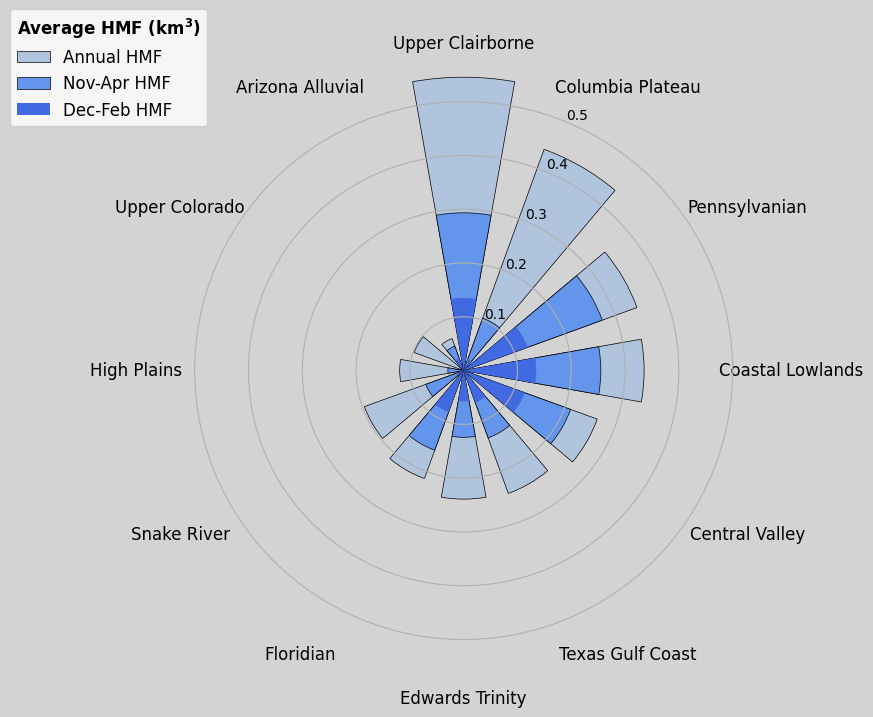

In [135]:
num_angles = len(aquifers)
angles = np.linspace(0, 2 * np.pi, num_angles, endpoint=False).tolist()
rad_pos = np.linspace(0, df_to_plot['annual_hmf'].max() * 1.2, 5)

fix, ax = plt.subplots(figsize=(8, 8), subplot_kw={'projection': 'polar'}, facecolor='lightgray')
ax.set_theta_offset(np.pi / 2)
ax.set_theta_direction(-1)

ax.bar(angles, df_to_plot['annual_hmf'], width=0.35, color='lightsteelblue', label="Annual HMF", edgecolor='black', linewidth=0.5, alpha=1.0)
ax.bar(angles, df_to_plot['six_mo_hmf'], width=0.35, color='cornflowerblue', label="Nov-Apr HMF", edgecolor='black', linewidth=0.5, alpha=1.0)
ax.bar(angles, df_to_plot['three_mo_hmf'], width=0.35, color='royalblue', label="Dec-Feb HMF", linewidth=0.5, alpha=1.0)

ax.set_xticks(np.linspace(0, 2 * np.pi, num_angles, endpoint=False))
ax.set_xticklabels([name for name in df_to_plot['aq_name']], fontsize=12)
ax.grid(False, axis='x')
ax.set_frame_on(False)

legend = plt.legend(alignment='left', fontsize=12, loc='upper left')
legend.set_title('Average HMF ($\mathregular{km^3}$)', {'weight': 'bold', 'size': 12})
legend.set_bbox_to_anchor((-0.25, 1.0, 0.1, 0.1))
plt.show()

## Plot 3: All Aquifer Metrics Violin Plots
Visualization of the 12 aquifers relative metrics

In [24]:
aquifers = cl.ALL_AQUIFERS
range = 30
quantile = 90
metric = 'inter_annual%'

dataset = f'Prelim_Data/_National_Metrics/National_Metrics_{range}_{quantile}.xlsx'
try:
    df_3 = pd.read_excel(dataset, dtype=fn.DATASET_DTYPES)
    df_3, _ = fn.filter_by_valid(df_3)
    df_3 = df_3.reset_index(drop=True)
except Exception as e:
    print(e)
    df_3 = pd.DataFrame() 

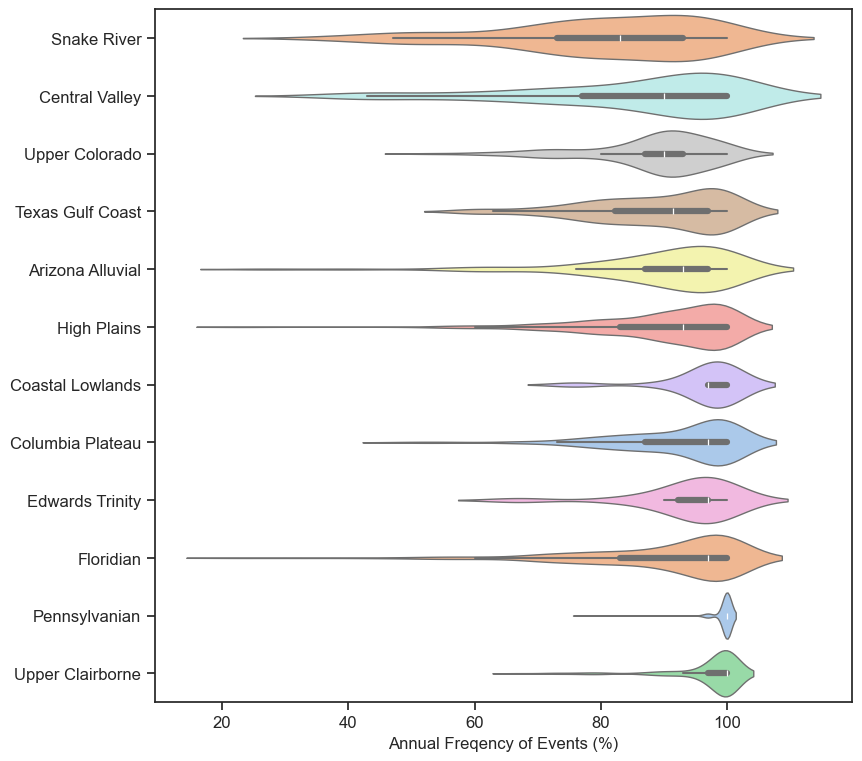

In [25]:
# Data init
# NOTE: Right now this uses a lazy method of assigning aquifers to sites, in which some sites are overwritten
# if they're part of more than one aquifer. Not an issue for general trend visualization, but should be corrected
# before this plot is used for anything more serious.
for i, row in df_3.iterrows():
    for aquifer in aquifers:
        if row['huc4_code'] in aquifer.huc4s:
            df_3.at[i, 'aq_name'] = aquifer.name            
            
df_to_plot = df_3[['aq_name', metric]].dropna()
order = df_to_plot.groupby('aq_name').median().sort_values(metric, ascending=True).index

sns.set_theme(style="ticks")
fig, ax = plt.subplots(figsize=(9, 9))
sns.violinplot(x=metric, y='aq_name', hue='aq_name', data=df_to_plot, order=order, density_norm='width', linewidth=1.0, orient='h', palette='pastel', legend=False)

yticks = [tick.get_text().replace('_', ' ') for tick in ax.get_yticklabels()]
ytick_pos = ax.get_yticks()
plt.xticks(fontsize=12)
plt.yticks(ytick_pos, yticks, fontsize=12)
# Tick marks for DOHY specifically
#plt.yticks([0, 61, 123, 183, 244, 305], ['Oct', 'Dec', 'Feb', 'Apr', 'Jun', 'Aug'], fontsize=12)
plt.xlabel(fn.FLOW_METRIC_UNITS[metric], fontsize=12)
plt.ylabel(None)
plt.show()
